In [1]:
"""
Example script of WaveBlocks framework.
This script uses a Fourier Light Field (FLF) microscope with a  Phase Mask (PM) and a Microlens Array (MLA)
Here, we define the microscope and forward project a volume of microspheres. 
We then use torch optimizers to reconstruct the volume.


# Erik Riedel & Josef Kamysek
# erik.riedel@tum.de & josef@kamysek.com
# 15/10/2020, Munich, Germany

"""

# Third party libraries imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import pathlib
import math
import logging
import random

# Waveblocks imports
import waveblocks
from waveblocks.microscopes import fourier_lightfield_mla_micro
from waveblocks.microscopes.fourier_lightfield_mla_micro import Microscope
from waveblocks.blocks.microlens_arrays import MLAType
from waveblocks.blocks.optic_config import OpticConfig
import waveblocks.blocks.point_spread_function as psf
from waveblocks.utils.helper import get_free_gpu
from waveblocks.utils import generate_phase_masks as pm
import waveblocks.evaluation.microspheres as ms
import waveblocks.reconstruction.deconvolution.optimizer_reconstruction as recon
import waveblocks.evaluation.reconstruction_analysis as fwhm
from waveblocks.utils.misc_tools import * #normalize_PSF_pair
from waveblocks.utils.misc_utils import ConcatDataset, plot_param_grads, load_PSF, imshow3D, imshow2D, psnr, plot_distributions_from_INN
from waveblocks.utils.XLFMDataset import XLFMDatasetFull, get_lenslet_centers

logger = logging.getLogger("Waveblocks")
waveblocks.set_logging(
    debug_mla=False,
    debug_microscope=False,
    debug_richardson_lucy=False,
    debug_optimizer=False,
)

torch.set_num_threads(8)

# Optical Parameters
depth_range = [-32, 32]
depth_step = 2
depths = np.arange(depth_range[0], depth_range[1] + depth_step, depth_step)
n_depths = len(depths)
# Change size of volume you are looking at
vol_xy_size = 151  # 17

# Configuration parameters
lr = 5e-2
max_volume = 1
n_epochs = 1
# Fetch Device to use
device = torch.device(
    "cuda:" + str(get_free_gpu()) if torch.cuda.is_available() else "cpu"
)


# A realistic shape is (1, 41, 191, 191) -> e.g. zebra fish brain image

# Create opticalConfig object with the information from the microscope
optic_config = fourier_lightfield_mla_micro.preset1()

# Update optical config from input PSF
# Lateral size of PSF in pixels
psf_size = 17 * 31  # 17 * 11

# Define PSF
PSF = psf.PSF(optic_config=optic_config, members_to_learn=[])
_, psf_in = PSF.forward(
    optic_config.sensor_pitch / optic_config.PSF_config.M, psf_size, depths
)

# Enable Fourier convolutions
optic_config.use_fft_conv = True

# Create Microscope
# List of all coordinates in the MLA
mla_coordinates = [
    (100, 250),
    (250, 250),
    (400, 250),
    (100, 100),
    (250, 100),
    (400, 100),
    (100, 400),
    (250, 400),
    (400, 400),
]
mla_shape = [psf_size, psf_size]  # [499, 499]

# Define phase mask
optic_config.use_pm = True
# Number of pixels in phase mask
# compute pixel size at fourier plane of first lens
Fs = 1.0 / optic_config.sensor_pitch
cycles_perum = Fs / psf_in.shape[-2]
# incoherent resolution limit
resolution_limit = optic_config.PSF_config.wvl / (
    optic_config.PSF_config.NA * optic_config.PSF_config.M
)
n_pix_in_fourier = resolution_limit / cycles_perum
# diameter of the objective back focal plane, which acts as the entrance pupil for our system
d_obj = optic_config.PSF_config.fobj * optic_config.PSF_config.NA
# sampling size on the fourier domain
fourier_metric_sampling = d_obj / n_pix_in_fourier

optic_config.pm_sampling = fourier_metric_sampling

# optic_config.pm_pixel_size = 8
optic_config.pm_pixel_size = 3.9

optic_config.pm_shape = [
    psf_size,
    psf_size,
]  # 512 [1054, 1054] # [187, 187] # [527,527]

optic_config.pm_max_phase_shift = 5.4 * math.pi

pm_image = pm.create_phasemask(
    pm.PhaseMaskType.cubic,
    pm.PhaseMaskShape.square,
    {
        "x": optic_config.pm_shape[0],
        "y": optic_config.pm_shape[1],
        "ratio": 0.4,  # 0.3,
        "offset": [0, 0],
    },
    information={"max_phase_shift": 5.4 * math.pi},
)

#plt.imshow(pm_image)
pm_image = torch.ones(optic_config.pm_shape[0],optic_config.pm_shape[1])

pm_image = pm_image.unsqueeze(0).unsqueeze(0).float()
# NOTE: Testing ones as initial PM
#pm_image = torch.ones(pm_image.shape)
pm_image = torch.tensor(pm_image, requires_grad=True, device=device)

wb_micro = Microscope(
    optic_config=optic_config,
    members_to_learn=[
        "phase_mask.function_img",
    ],
    psf_in=psf_in,
    mla_coordinates=mla_coordinates,
    mla_shape=mla_shape,
    pm_image=pm_image,
).to(device)
init_phase_mask = wb_micro.phase_mask.function_img
wb_micro.phase_mask.function_img.retain_grad()

wb_micro.eval()

<ipython-input-1-d788a6a4b32e>:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pm_image = torch.tensor(pm_image, requires_grad=True, device=device)
Waveblocks - INFO - Initialized BaseMLA
Waveblocks - INFO - Computing Block Image ... 
Waveblocks - INFO - Successfully Computed Block Image!
Waveblocks - INFO - Computing Full Image ...
Waveblocks - INFO - Successfully Computed Full Image!
Waveblocks - INFO - Initialized CoordinateMLA


Microscope(
  (optic_config): OpticConfig()
  (lens1): Lens(
    (optic_config): OpticConfig()
    (wave_prop_obj): WavePropagation(
      (optic_config): OpticConfig()
    )
    (wave_prop_img): WavePropagation(
      (optic_config): OpticConfig()
    )
  )
  (phase_mask): PhaseMask(
    (optic_config): OpticConfig()
  )
  (mla): CoordinateMLA(
    (optic_config): OpticConfig()
  )
  (mla2sensor): WavePropagation(
    (optic_config): OpticConfig()
  )
  (camera): Camera(
    (optic_config): OpticConfig()
  )
)

In [2]:
dataset = []
dataset_test_array = []

volumes_input_path = "/u/home/vizcainj/share-all/XLFM-data/real_images/dataset_fish2_new"
print('Loading data from ' + volumes_input_path)
images_to_use = list(range(0,148,1))
volume_ths = 0
volume_norm_func = "max"
lenslet_file = "/u/home/vizcainj/code/SLNet_XLFMNet_unsupervised/WaveBlocks_INN/example_scripts/INN/lenslet_centers_python.txt"

# Lateral size of PSF in pixels
psf_size_real = 2160
psf_size_optimal = 2048


with torch.no_grad():
        dataset.append(
            XLFMDatasetFull(volumes_input_path, lenslet_file, 2*[psf_size_optimal], img_shape=2*[psf_size_real],
                images_to_use=images_to_use, divisor=1, isTiff=True, n_frames_net=1, lenslets_offset=0,
                load_all=True, load_vols=True, load_sparse=False,
                border_blanking=0, eval_video=True)
        )
        # Reshape volumes
        dataset[-1].vols = load_process_volume(dataset[-1].vols, [vol_xy_size, vol_xy_size, n_depths], dark_current_ths=volume_ths, norm=volume_norm_func).float()
        dataset[-1].stacked_views = dataset[-1].stacked_views.float()
        

# # Creating data indices for training and validation splits:
# full_dataset = ConcatDataset(*dataset)



volumes = dataset[0].vols # torch.Size([148, 33, 151, 151])



Loading data from /u/home/vizcainj/share-all/XLFM-data/real_images/dataset_fish2_new
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
Loaded 148


Waveblocks - DEBUG - loss = tensor(2.9484, device='cuda:0', grad_fn=<SumBackward0>) - 0.00 %% done (<ipython-input-6-2d7b37c8fe84>:74)
Waveblocks - DEBUG - loss = tensor(2.6372, device='cuda:0', grad_fn=<SumBackward0>) - 4.73 %% done (<ipython-input-6-2d7b37c8fe84>:74)
Waveblocks - DEBUG - loss = tensor(1.8466, device='cuda:0', grad_fn=<SumBackward0>) - 9.46 %% done (<ipython-input-6-2d7b37c8fe84>:74)
Waveblocks - DEBUG - loss = tensor(1.5991, device='cuda:0', grad_fn=<SumBackward0>) - 14.19 %% done (<ipython-input-6-2d7b37c8fe84>:74)
Waveblocks - DEBUG - loss = tensor(1.2560, device='cuda:0', grad_fn=<SumBackward0>) - 18.92 %% done (<ipython-input-6-2d7b37c8fe84>:74)
Waveblocks - DEBUG - loss = tensor(1.0956, device='cuda:0', grad_fn=<SumBackward0>) - 23.65 %% done (<ipython-input-6-2d7b37c8fe84>:74)
Waveblocks - DEBUG - loss = tensor(0.9917, device='cuda:0', grad_fn=<SumBackward0>) - 28.38 %% done (<ipython-input-6-2d7b37c8fe84>:74)
Waveblocks - DEBUG - loss = tensor(0.9385, device='

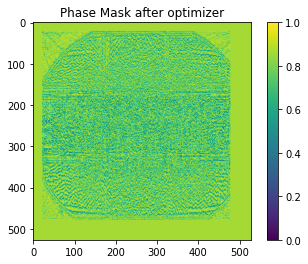

In [6]:
num_epochs = volumes.shape[0]

# Create optimizer and loss function
test = {"params": wb_micro.phase_mask.function_img, "lr": 13}
optimizer = torch.optim.Adam([test])
# optimizer = torch.optim.SGD([test], lr=0.1, momentum=0.9)
from waveblocks.utils.misc_utils import log_likelehood

# crit = torch.nn.MSELoss()
# crit = log_likelehood
def total_variation_loss(img, weight):
    bs_img, c_img, h_img, w_img = img.size()
    tv_h = torch.pow(img[:, :, 1:, :] - img[:, :, :-1, :], 2).sum()
    tv_w = torch.pow(img[:, :, :, 1:] - img[:, :, :, :-1], 2).sum()
    return weight * (tv_h + tv_w) / (bs_img * c_img * h_img * w_img)

def extract_ampl_phase(fft_im):
    # fft_im: size should be bx3xhxwx2
    fft_amp = torch.pow(fft_im[:,:,:,0],2)+ torch.pow(fft_im[:,:,:,1],2)
    fft_amp = torch.sqrt(fft_amp)
    return fft_amp



loss = 0

display_modulo = math.floor(num_epochs / 20)
if display_modulo == 0:
    display_modulo = 1

for epoch in range(num_epochs):

    optimizer.zero_grad()
    wb_micro.zero_grad()

    gt_volume = volumes[epoch, :, :, :].float().unsqueeze(0).unsqueeze(0).to(device)

    gt_volume = gt_volume[:, 0, ...].contiguous()
    gt_flf_img = wb_micro(gt_volume, compute_psf=True, full_psf_graph=True)

    wb_micro.camera.fft_paddings_ready = False

    volume_pred = wb_micro.camera.forward(gt_flf_img, wb_micro.psf.float(), is_backwards=True, full_psf_graph=True)

    vol_pred_crop_width = gt_volume.shape[2]
    vol_pred_crop_height = gt_volume.shape[3]
    vol_pred_center_x = math.floor(volume_pred[0].shape[2] / 2)
    vol_pred_center_y = math.floor(volume_pred[0].shape[3] / 2)
    volume_pred = volume_pred[0][
        :,
        :,
        vol_pred_center_x - math.floor(vol_pred_crop_width / 2) : vol_pred_center_x + math.ceil(vol_pred_crop_width / 2),
        vol_pred_center_y - math.floor(vol_pred_crop_height / 2) : vol_pred_center_y + math.ceil(vol_pred_crop_height / 2),
    ]

    normalized_volume = normalize_PSF_pair(volume_pred, gt_volume)

    # loss = crit(normalized_volume, gt_volume)
    fft_src = torch.fft.rfft(gt_volume) 
    fft_trg = torch.fft.rfft(normalized_volume)

    # extract amplitude and phase of both ffts
    amp_src = extract_ampl_phase(fft_src)
    amp_trg = extract_ampl_phase(fft_trg)

    test = torch.abs(amp_src - amp_trg)
    loss = test.mean()  


    loss.backward()
    optimizer.step()

    if epoch % display_modulo == 0:
        logger.debug_override(
            "loss = {} - {:.2f} %% done".format(
                str(loss.sum()),
                (100 * epoch / num_epochs),
            )
        )

    # loss_plot.append(loss.item())


# remove random high value and normalize value
test_volume = wb_micro.phase_mask.function_img.detach()
test_volume[test_volume > 100] = 1
test_volume = (test_volume - torch.min(test_volume)) / (torch.max(test_volume) - torch.min(test_volume))

plt.imshow(test_volume[0, 0, :, :].detach().cpu().numpy())
plt.colorbar()
plt.title("Phase Mask after optimizer")
plt.show()


In [4]:
# torch.save(test_volume[0,0,:,:],"log_likeli_PM")
torch.save(test_volume[0,0,:,:],"fft_loss_PM")
